## PersiteWrapper

This is where I develop the `PersiteWrapper` and test if we should use regularization. 
The answer is no. 
It is in `models.py` now, without regularization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from netam import framework, models
from epam.torch_common import pick_device, print_parameter_count

/Users/matsen/mambaforge/envs/epam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df, val_df = framework.load_shmoof_dataframes("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv", val_nickname="59") #, sample_count=5000)

In [3]:
kmer_length = 1
max_length = 410

train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

device = pick_device()
train_dataset.to(device)
val_dataset.to(device)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

Using Metal Performance Shaders
we have 44330 training examples and 4686 validation examples


In [4]:
class PersiteWrapper(nn.Module):
    """
    This wraps another model, but adds a per-site component.
    """
    def __init__(self, base_model, dataset, penalty_weight=0.0):
        super(PersiteWrapper, self).__init__()
        self.base_model = base_model
        self.site_count = dataset.max_length
        self.penalty_weight = penalty_weight
        self.log_site_rates = nn.Embedding(self.site_count, 1)

    def forward(self, encoded_parents, masks):
        base_model_rates = self.base_model(encoded_parents, masks)
        sequence_length = encoded_parents.size(1)
        positions = torch.arange(sequence_length, device=encoded_parents.device)
        log_site_rates = self.log_site_rates(positions).T
        rates = base_model_rates * torch.exp(log_site_rates)
        return rates
    
    def regularization_loss(self):
        reg_loss = torch.sum(self.log_site_rates.weight ** 2)
        reg_loss *= self.penalty_weight
        return reg_loss 

    @property
    def site_rates(self):
        # Convert site log rates to linear space
        return torch.exp(self.log_site_rates.weight).squeeze()


In [5]:
base_model_dict = {
        "cnn_sml": models.CNNModel(train_dataset, embedding_dim=6, num_filters=14, kernel_size=7, dropout_rate=0.0),
        "cnn_med": models.CNNModel(train_dataset, embedding_dim=9, num_filters=9, kernel_size=11, dropout_rate=0.1),
        "cnn_lrg": models.CNNModel(train_dataset, embedding_dim=7, num_filters=19, kernel_size=11, dropout_rate=0.3),
    }

base_model = base_model_dict["cnn_med"]
base_model.to(device)

CNNModel(
  (kmer_embedding): Embedding(5, 9)
  (conv): Conv1d(9, 9, kernel_size=(11,), stride=(1,), padding=same)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=9, out_features=1, bias=True)
)

In [6]:
base_burrito = framework.Burrito(train_dataset, val_dataset, base_model, batch_size=1024, learning_rate=0.1, min_learning_rate=1e-5, l2_regularization_coeff=1e-6)
print("starting training...")
losses = base_burrito.train(epochs=100)
losses.tail()

starting training...


Epoch:  53%|█████▎    | 53/100 [12:20<10:57, 13.98s/it, loss_diff=-1.747e-07, lr=6.4e-6] 


,train_loss,val_loss
49,0.061875,0.058413
50,0.061871,0.058413
51,0.061884,0.058413
52,0.061885,0.058414
53,0.061869,0.058413


In [7]:
base_model.eval() # Turn off training mode for the base model
for param in base_model.parameters():
    param.requires_grad = False

model = PersiteWrapper(base_model_dict["cnn_med"], train_dataset)
model.to(device)
burrito = framework.Burrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, min_learning_rate=1e-5, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=100)
losses.tail()

starting training...


Epoch:  38%|███▊      | 38/100 [03:39<05:58,  5.78s/it, loss_diff=-3.628e-09, lr=6.4e-6] 


,train_loss,val_loss
34,0.061335,0.058353
35,0.061318,0.058353
36,0.061325,0.058353
37,0.061318,0.058353
38,0.061322,0.058353


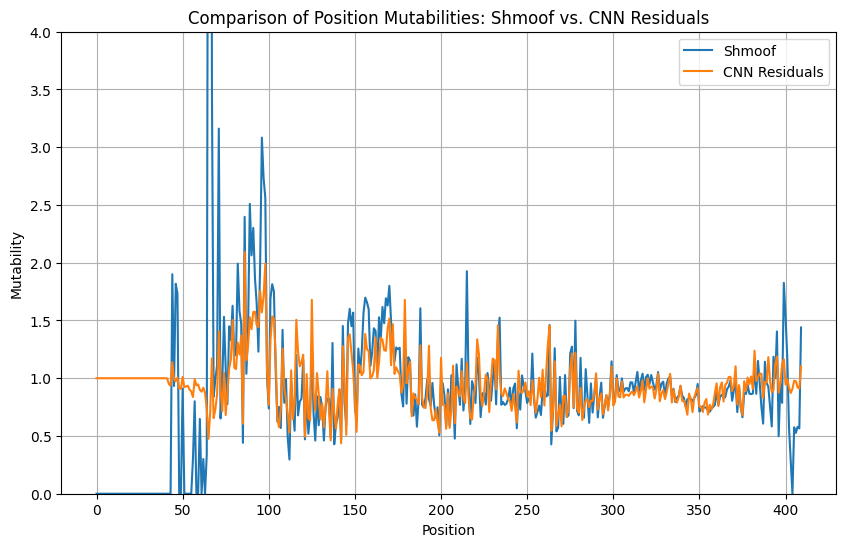

In [8]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
# Move to 0-indexing
shmoof_positions["Position"] -= 1
cnn_residuals = torch.exp(model.log_site_rates.weight).cpu().squeeze().detach().numpy()
cnn_residuals = pd.DataFrame({'Position': np.arange(len(cnn_residuals)), 'Mutability': cnn_residuals})

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, cnn_residuals, on='Position', suffixes=('_shmoof', '_cnn_residuals'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_cnn_residuals'], label='CNN Residuals')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.ylim(0, 4)

plt.title('Comparison of Position Mutabilities: Shmoof vs. CNN Residuals')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
base_model = models.CNNModel(train_dataset, embedding_dim=9, num_filters=9, kernel_size=11, dropout_rate=0.1)
model = PersiteWrapper(base_model, train_dataset)
model.to(device)
burrito = framework.Burrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, min_learning_rate=1e-5, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=100)
losses.tail()

starting training...


Epoch:  52%|█████▏    | 52/100 [13:41<12:37, 15.79s/it, loss_diff=1.109e-07, lr=6.4e-6]  


,train_loss,val_loss
48,0.060960,0.058086
49,0.060974,0.058086
50,0.060973,0.058086
51,0.060974,0.058086
52,0.060961,0.058086


In [10]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
results = []
best_validation_loss = float('inf')

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    base_model = models.CNNModel(train_dataset, embedding_dim=9, num_filters=9, kernel_size=11, dropout_rate=0.1)
    model = PersiteWrapper(base_model, train_dataset, penalty_weight=coeff)
    model.to(device)
    burrito = framework.Burrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-7)
    loss_history = burrito.train(epochs=100)
    final_training_loss = loss_history['train_loss'].iloc[-1]
    final_validation_loss = loss_history['val_loss'].iloc[-1]
    if final_validation_loss < best_validation_loss:
        best_validation_loss = final_validation_loss
        best_model = model

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)
regularization_results_df

Training with regularization coefficient 0


Epoch:  37%|███▋      | 37/100 [09:00<15:21, 14.62s/it, loss_diff=1.221e-06, lr=3.2e-5]  


Training with regularization coefficient 1e-08


Epoch:  38%|███▊      | 38/100 [09:28<15:27, 14.95s/it, loss_diff=-2.288e-07, lr=3.2e-5] 


Training with regularization coefficient 1e-07


Epoch:  45%|████▌     | 45/100 [10:09<12:25, 13.55s/it, loss_diff=3.755e-08, lr=3.2e-5]  


Training with regularization coefficient 1e-06


Epoch:  47%|████▋     | 47/100 [10:38<11:59, 13.58s/it, loss_diff=-2.227e-07, lr=3.2e-5] 


Training with regularization coefficient 1e-05


Epoch:  40%|████      | 40/100 [10:08<15:13, 15.22s/it, loss_diff=-8.578e-07, lr=3.2e-5] 


Training with regularization coefficient 0.0001


Epoch:  41%|████      | 41/100 [10:28<15:04, 15.33s/it, loss_diff=7.099e-07, lr=3.2e-5]  


Training with regularization coefficient 0.001


Epoch:  44%|████▍     | 44/100 [10:54<13:52, 14.87s/it, loss_diff=-4.204e-08, lr=3.2e-5] 


Training with regularization coefficient 0.01


Epoch:  80%|████████  | 80/100 [18:12<04:33, 13.66s/it, loss_diff=-4.636e-08, lr=3.2e-5] 


,Regularization,Final_Training_Loss,Final_Validation_Loss
0,0.000000e+00,0.061178,0.058250
1,1.000000e-08,0.060994,0.058173
2,1.000000e-07,0.062077,0.059230
3,1.000000e-06,0.062045,0.059010
4,1.000000e-05,0.061417,0.058212
5,1.000000e-04,0.061770,0.058322
6,1.000000e-03,0.061939,0.058472
7,1.000000e-02,0.063945,0.060069


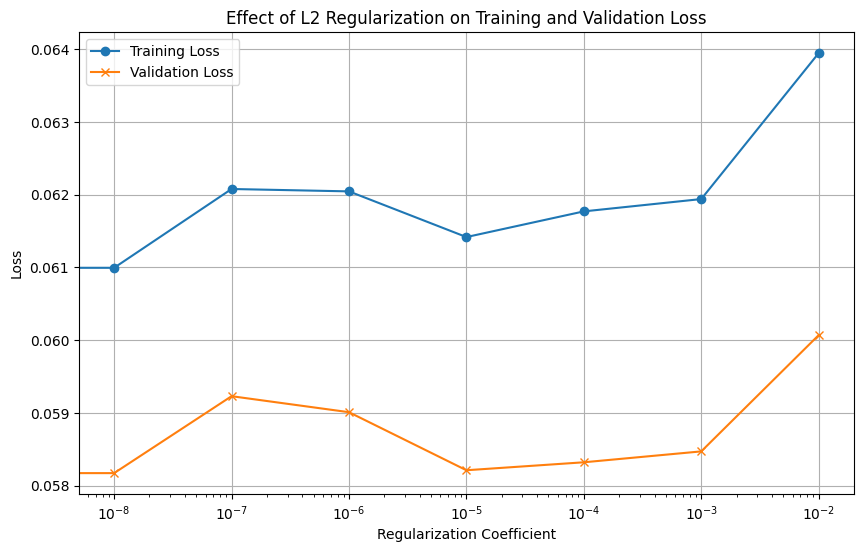

,Regularization,Final_Training_Loss,Final_Validation_Loss
0,0.000000e+00,0.061178,0.058250
1,1.000000e-08,0.060994,0.058173
2,1.000000e-07,0.062077,0.059230
3,1.000000e-06,0.062045,0.059010
4,1.000000e-05,0.061417,0.058212
5,1.000000e-04,0.061770,0.058322
6,1.000000e-03,0.061939,0.058472
7,1.000000e-02,0.063945,0.060069


In [11]:
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

regularization_results_df

Conclusion: don't regularize the site rates, it doesn't help.